# Forecast of O3 data: LSTM

## Import required modules

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from datetime import datetime

2022-06-20 19:10:06.277157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-20 19:10:06.277206: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import data sets

In [3]:
compressed = np.load("O3_model/transformed_datasets.npz",
             allow_pickle = True)

In [4]:
compressed.files

['x_train', 'x_test', 'y_train', 'y_test', 'dt_train', 'dt_test']

In [5]:
# Force arrays into float32 types; otherwise, Keras is unhappy.
ds = {}
for array in ['x_train', 'x_test', 'y_train', 'y_test']:
    ds[array] = compressed[array].astype(np.float32)

## Train & evaluate a simple model

In [6]:
calls = [EarlyStopping(monitor = "val_loss",
                       patience = 3)]

In [7]:
model_monolayer = Sequential()
model_monolayer.add(LSTM(units = 50,
                    activation = "tanh",
                    input_shape = (ds["x_train"].shape[1],
                               ds["x_train"].shape[2])
                    ))
model_monolayer.add(Dense(1))
model_monolayer.compile(loss = "mse",
                        metrics = ["mse", "mae"],
                        optimizer = "adam")

2022-06-20 19:10:12.594074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-20 19:10:12.594142: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-20 19:10:12.594182: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dwarven-notebook): /proc/driver/nvidia/version does not exist
2022-06-20 19:10:12.594704: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


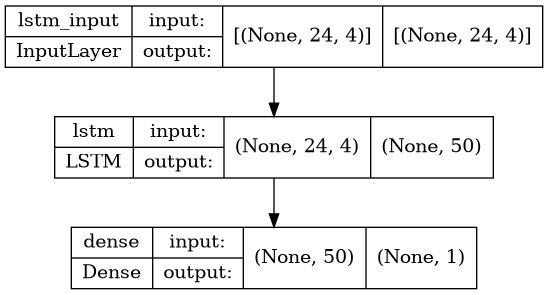

In [8]:
plot_model(model_monolayer,
           show_shapes = True,
           expand_nested = True)

In [9]:
history_monolayer = model_monolayer.fit(ds["x_train"],
                              ds["y_train"],
                              epochs = 20,
                              batch_size = 32,
                              verbose = 1,
                              validation_data = (ds["x_test"], ds["y_test"]),
                              shuffle = False,
                              callbacks = calls)

Epoch 1/20
3683/3683 [==============================] - 63s 16ms/step - loss: 146.8290 - mse: 146.8290 - mae: 8.2386 - val_loss: 43.5427 - val_mse: 43.5427 - val_mae: 4.6611
Epoch 2/20
3683/3683 [==============================] - 64s 17ms/step - loss: 36.7307 - mse: 36.7307 - mae: 3.8994 - val_loss: 31.0829 - val_mse: 31.0829 - val_mae: 3.9483
Epoch 3/20
3683/3683 [==============================] - 60s 16ms/step - loss: 31.9999 - mse: 31.9999 - mae: 3.6351 - val_loss: 28.5072 - val_mse: 28.5072 - val_mae: 3.8063
Epoch 4/20
3683/3683 [==============================] - 60s 16ms/step - loss: 30.2156 - mse: 30.2156 - mae: 3.5405 - val_loss: 26.6417 - val_mse: 26.6417 - val_mae: 3.6376
Epoch 5/20
3683/3683 [==============================] - 63s 17ms/step - loss: 29.1297 - mse: 29.1297 - mae: 3.4751 - val_loss: 25.7108 - val_mse: 25.7108 - val_mae: 3.5619
Epoch 6/20
3683/3683 [==============================] - 63s 17ms/step - loss: 28.4205 - mse: 28.4205 - mae: 3.4294 - val_loss: 25.1099 - v

In [10]:
model_monolayer.save("O3_model/model_monolayer")

2022-06-20 19:24:44.334028: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: O3_model/model_monolayer/assets


INFO:tensorflow:Assets written to: O3_model/model_monolayer/assets


In [11]:
history_mono_df = pd.DataFrame(history_monolayer.history)

<AxesSubplot:>

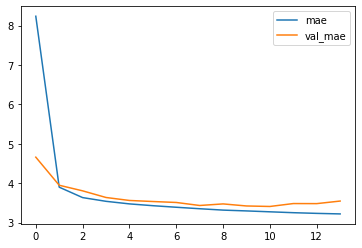

In [12]:
history_mono_df.plot(kind = "line", y = ["mae", "val_mae"])

In [13]:
preds_mono = pd.DataFrame(model_monolayer.predict(ds["x_test"]), columns = ["predicted_O3"])

In [14]:
preds_mono["measured_O3"] = ds["y_test"]
preds_mono["DateTime"] = compressed["dt_test"]

In [15]:
preds_mono.head()

,predicted_O3,measured_O3,DateTime
0,34.987709,38.0,2015-05-26 01:00:00
1,38.687859,37.0,2015-05-26 02:00:00
2,37.369648,39.0,2015-05-26 03:00:00
3,38.333836,33.0,2015-05-26 04:00:00
4,28.641281,30.0,2015-05-26 05:00:00


<AxesSubplot:xlabel='DateTime'>

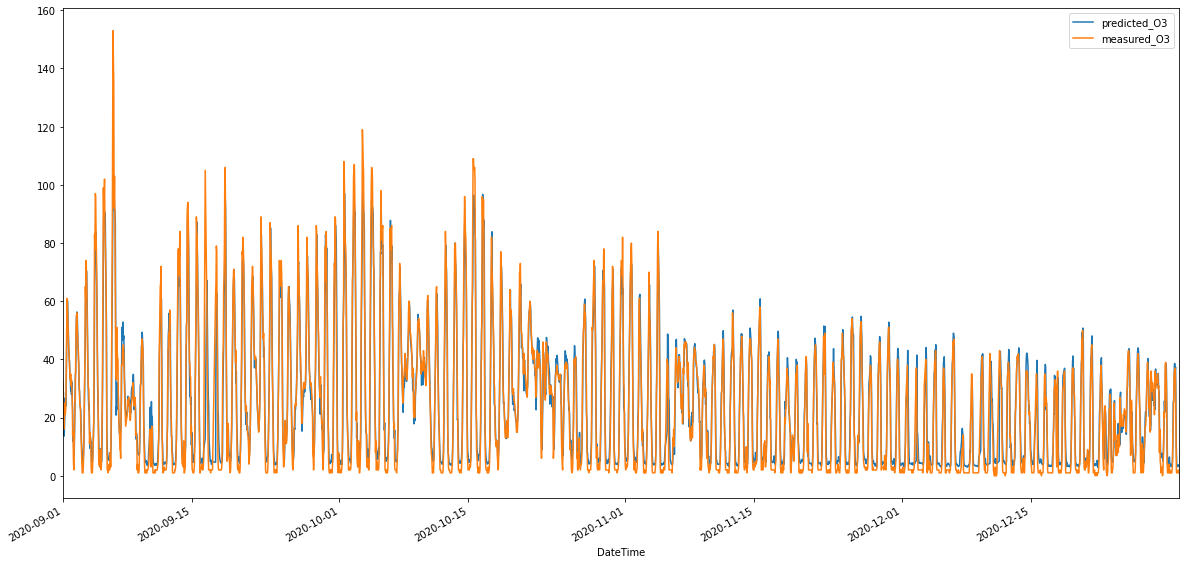

In [16]:
preds_mono.plot(kind = "line",
                y = ["predicted_O3", "measured_O3"],
                x = "DateTime",
                figsize = (20, 10),
                xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
                subplots = False)

## Evaluate the impact of adding a second LSTM layer.
As a control, keep the total number of neurons constant vs. the first model (50).

In [17]:
model_bilayer = Sequential()
model_bilayer.add(LSTM(units = 25,
                  activation = "tanh",
                  input_shape = (ds["x_train"].shape[1],
                                 ds["x_train"].shape[2]),
                  return_sequences = True
                  ))
model_bilayer.add(LSTM(units = 25,
                    activation = "tanh"))
model_bilayer.add(Dense(1))
model_bilayer.compile(loss = "mse",
                        metrics = ["mse", "mae"],
                        optimizer = "adam")

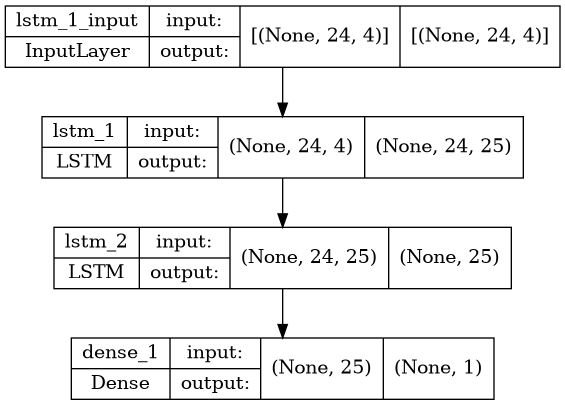

In [18]:
plot_model(model_bilayer,
           show_shapes = True,
           expand_nested = True)

In [19]:
history_bilayer = model_bilayer.fit(ds["x_train"],
                              ds["y_train"],
                              epochs = 20,
                              batch_size = 32,
                              verbose = 1,
                              validation_data = (ds["x_test"], ds["y_test"]),
                              shuffle = False,
                              callbacks = calls)

Epoch 1/20
3683/3683 [==============================] - 95s 24ms/step - loss: 290.7194 - mse: 290.7194 - mae: 13.2562 - val_loss: 145.3215 - val_mse: 145.3215 - val_mae: 8.9827
Epoch 2/20
3683/3683 [==============================] - 88s 24ms/step - loss: 66.1785 - mse: 66.1785 - mae: 5.1293 - val_loss: 42.9024 - val_mse: 42.9024 - val_mae: 4.4814
Epoch 3/20
3683/3683 [==============================] - 78s 21ms/step - loss: 38.3340 - mse: 38.3340 - mae: 3.8980 - val_loss: 31.8289 - val_mse: 31.8289 - val_mae: 3.8438
Epoch 4/20
3683/3683 [==============================] - 67s 18ms/step - loss: 32.5432 - mse: 32.5432 - mae: 3.6550 - val_loss: 28.0363 - val_mse: 28.0363 - val_mae: 3.6412
Epoch 5/20
3683/3683 [==============================] - 67s 18ms/step - loss: 30.5130 - mse: 30.5130 - mae: 3.5503 - val_loss: 26.5261 - val_mse: 26.5261 - val_mae: 3.5198
Epoch 6/20
3683/3683 [==============================] - 67s 18ms/step - loss: 29.5149 - mse: 29.5149 - mae: 3.4978 - val_loss: 26.1256 

In [20]:
model_bilayer.save("O3_model/model_bilayer")

INFO:tensorflow:Assets written to: O3_model/model_bilayer/assets


INFO:tensorflow:Assets written to: O3_model/model_bilayer/assets


In [21]:
history_bi_df = pd.DataFrame(history_bilayer.history)

<AxesSubplot:>

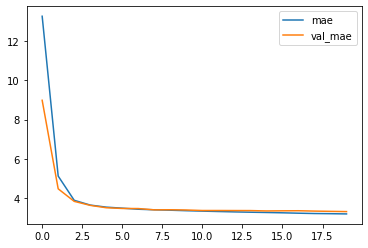

In [22]:
history_bi_df.plot(kind = "line", y = ["mae", "val_mae"])

In [23]:
preds_bi = pd.DataFrame(model_bilayer.predict(ds["x_test"]), columns = ["predicted_O3"])

In [24]:
preds_bi["measured_O3"] = ds["y_test"]
preds_bi["DateTime"] = compressed["dt_test"]

In [25]:
preds_bi.head()

,predicted_O3,measured_O3,DateTime
0,34.206913,38.0,2015-05-26 01:00:00
1,37.562267,37.0,2015-05-26 02:00:00
2,35.553734,39.0,2015-05-26 03:00:00
3,37.827984,33.0,2015-05-26 04:00:00
4,27.274050,30.0,2015-05-26 05:00:00


<AxesSubplot:xlabel='DateTime'>

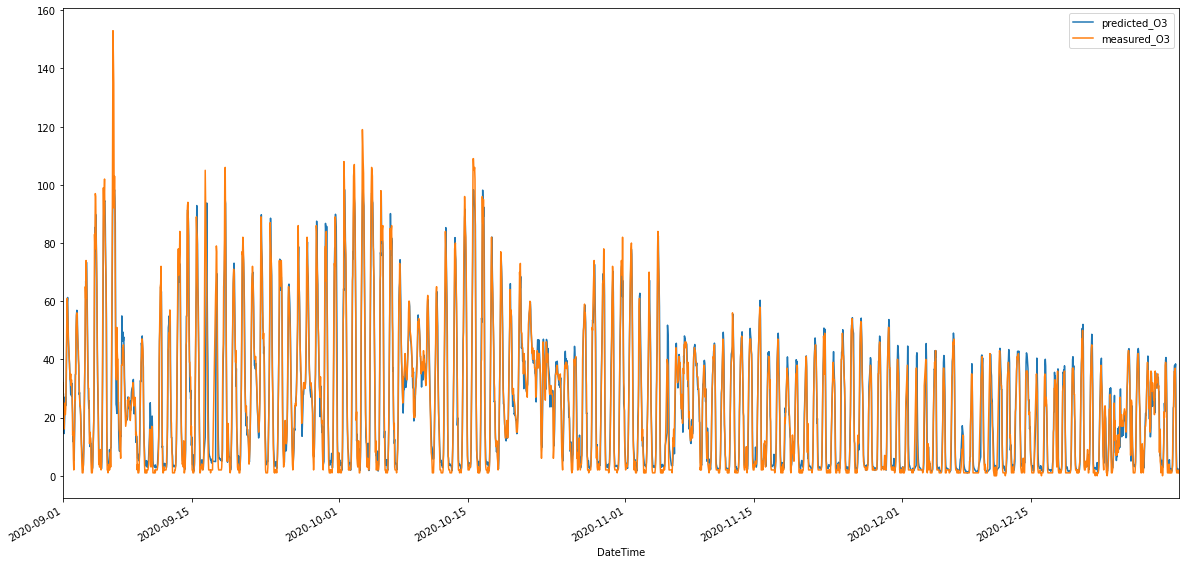

In [26]:
preds_bi.plot(kind = "line",
                y = ["predicted_O3", "measured_O3"],
                x = "DateTime",
                figsize = (20, 10),
                xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
                subplots = False)

## Compare the two models

In [27]:
# Combine predictions from both models into a single dataframe
preds = preds_bi[["DateTime", "measured_O3"]]
preds["pred_O3_bilayer"] = preds_bi["predicted_O3"]
preds["pred_O3_monolayer"] = preds_mono["predicted_O3"]

In [28]:
# Calculate absolute error for reach model & timepoint
preds["mono_abs_err"] = abs(preds["pred_O3_monolayer"] - preds["measured_O3"])
preds["bi_abs_err"] = abs(preds["pred_O3_bilayer"] - preds["measured_O3"])
preds.head()

,DateTime,measured_O3,pred_O3_bilayer,pred_O3_monolayer,mono_abs_err,bi_abs_err
0,2015-05-26 01:00:00,38.0,34.206913,34.987709,3.012291,3.793087
1,2015-05-26 02:00:00,37.0,37.562267,38.687859,1.687859,0.562267
2,2015-05-26 03:00:00,39.0,35.553734,37.369648,1.630352,3.446266
3,2015-05-26 04:00:00,33.0,37.827984,38.333836,5.333836,4.827984
4,2015-05-26 05:00:00,30.0,27.274050,28.641281,1.358719,2.725950


In [29]:
# Calculate MAE
preds[["mono_abs_err", "bi_abs_err"]].mean()

mono_abs_err    3.547118
bi_abs_err      3.324310
dtype: float32

These two models give comparable performance, but the monolayered model trained in roughly half the time. This model should be used as the starting point for future refinement.